In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
import unittest
from IPython.display import display

In [21]:
class Service:
    # Function for integration
    # f: calleble function - function
    # a: float - left boundary
    # b: float - right boundary
    # margin: float - error
    @staticmethod
    def integrate(f, a: float, b:float , margin=0.001):
        if a > b:
            raise ValueError("left bounder must be lower then right")
        area = 0
        while (abs(b-a) > margin):
            area += margin*f(a+margin/2)
            a += margin
        return area

In [22]:
class Laguerre:
    def __init__(self, func, T, beta: int, sigma: int, N: int, epsilon=1e-3):
        if beta > sigma:
            raise ValueError("sigma must be greater than beta")
        self._func = func #: calleble function - function
        self.T = T # : float - ceil value for calculating experiment
        self.beta = beta #: float - beta for laguerre function
        self.sigma = sigma #: float - sigma for laguerre function
        self.N = N # int - max power of laguerre function
        self.epsilon = epsilon #: float - calculation error
        self._recalc()

    @property
    def func(self):
        return self._func

    @func.setter
    def func(self, value):
        print("This is read-only value")

    @property
    def laguerre_transformation_value(self):
        if self._laguerre_transformation_value is None:
            self._laguerre_transformation_value = self.laguerre_transformation()
        return self._laguerre_transformation_value

    @laguerre_transformation_value.setter
    def laguerre_transformation_value(self, value):
        print("This is read-only value")

    @property
    def experiment_value(self):
        if self._experiment_value is None:
            self._experiment_value = self.experiment()
        return self._experiment_value

    @experiment_value.setter
    def experiment_value(self, value):
        print("This is read-only value")

    @property
    def T(self):
        return self._T

    @T.setter
    def T(self, value):
        if value <= 0:
            raise ValueError("T must be positive")
        self._recalc()
        self._T = value

    @property
    def beta(self):
        return self._beta

    @beta.setter
    def beta(self, value):
        if value < 0:
            raise ValueError("Beta must be non-negative")
        self._recalc()
        self._beta = value

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, value):
        if value < 0:
            raise ValueError("Sigma must be non-negative")
        self._recalc()
        self._sigma = value

    @property
    def N(self):
        return self._N

    @N.setter
    def N(self, value):
        if value < 1:
            raise ValueError("N must be at least 1")
        self._recalc()
        self._N = value

    @property
    def epsilon(self):
        return self._epsilon

    @epsilon.setter
    def epsilon(self, value):
        if value <= 0:
            raise ValueError("Epsilon must be positive")
        self._recalc()
        self._epsilon = value

    def _recalc(self):
        self._experiment_value = None
        self._laguerre_transformation_value = None

    def laguerre_function(self, t, n):
        if self.beta < 0 or self.beta > self.sigma or n < 0:
            raise ValueError("Wrong parameters")

        lpp = np.sqrt(self.sigma)*np.exp(-self.beta*t/2)
        lp = np.sqrt(self.sigma)*(1 - self.sigma*t)*np.exp(-self.beta*t/2)

        if n == 0:
            return lpp
        if n == 1:
            return lp

        for i in range(2, n+1):
            temp = lp
            lp = (2*i - 1 - self.sigma*t)*lp/i - (i-1)*lpp / i
            lpp = temp

        return lp

    def experiment(self):
        t = np.linspace(0, self.T, 1000)
        n = range(0, self.N+1)
        true_for_all = False
        result = 0
        for i in t:
            for j in n:
                if abs(self.laguerre_function(i, j)) < self.epsilon:
                    true_for_all = True
                else:
                    true_for_all = False
            if true_for_all:
                result = i
                break
        else:
            result = None
        if result == None:
            raise "The experiment is failed, there is no T that satisfy condition. You can set bigger max T to check"
        self._experiment_value = result
        return result

    def laguerre_transformation(self):
        to = self.experiment_value
        result = [Service.integrate(lambda t: self._func(t)*self.laguerre_function(t, k)
                                    * np.exp(-t*(self.sigma-self.beta)), 0, to, self.epsilon) for k in range(self.N+1)]
        self._laguerre_transformation_value = result
        return result

    def reverse_laguerre_transformation(self, t):
        sum = 0
        for k in range(self.N):
            sum += self.laguerre_transformation_value[k] * \
                self.laguerre_function(t, k)
        return sum


In [23]:
class Laguerre_Tabulator(Laguerre):
    def __init__(self, func, T, beta, sigma, N, epsilon):
        if beta > sigma:
            raise ValueError("sigma must be greater than beta")
        super().__init__(func, T, beta, sigma, N, epsilon)

    def tabulate_laguerre(self, n, to):
        t = np.linspace(1, to, to)
        results = self.laguerre_function(t, n)
        df = pd.DataFrame({'t': t, 'l(t)': results})
        return df

    def tabulate_experiment(self):
        t = self.experiment_value
        lt_values = []
        for n in range(0, self.N+1):
            lt_values.append(self.laguerre_function(t, n))
        cols = {"t": [t]*(self.N+1), "n": range(0,
                                                self.N+1), "L(t)": lt_values}

        return pd.DataFrame(cols)

    def tabulate_laguerre_transformation(self):
        transformed = self.laguerre_transformation_value
        cols = {"n": range(0, self.N+1),
                "transformed": transformed}
        return pd.DataFrame(cols).round(5)


In [24]:
class Visualize:
    @staticmethod
    def draw_lauguerre(laguerre_instance, t=None):
        if t is None:
            t = laguerre_instance.experiment_value
        x = np.arange(0, t, 0.01)
        fig, ax = plt.subplots()
        ax.set_title(r'Laguerre polynomials $L_n$')
        for n in np.arange(0, laguerre_instance.N+1):
            ax.plot(x, laguerre_instance.laguerre_function(
                x, n), label=rf'$L_{n}$')
        plt.xlabel('t')
        plt.ylabel('L(t)')
        plt.title('Plot of Laguerre function')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def draw_reverse_transformation(laguerre_instance, a: float, b: float):
        if a < 0:
            raise ValueError("left boundary must be >= 0")

        def reverse_transformation_func(t):
            return laguerre_instance.reverse_laguerre_transformation(t)
        num = int((b-a)*100)
        t_values = np.linspace(a, b, num)
        f_y_values = np.vectorize(laguerre_instance.func)(t_values)
        f_rlt_y_values = np.vectorize(reverse_transformation_func)(t_values)
        plt.plot(t_values, f_y_values, label=f"Function")
        plt.plot(t_values, f_rlt_y_values,
                 label="Reverse laguerre transformation")
        plt.xlabel('t')
        plt.ylabel('Function Value')
        plt.title(f'Plot of {laguerre_instance.func.__name__}')
        plt.legend()
        plt.grid(True)
        plt.show()


In [25]:
class UI:
    def __init__(self, laguerre_instance):
        self.laguerre_instance = laguerre_instance
        self.laguerre_tabulator_instance = Laguerre_Tabulator(
            laguerre_instance.func, laguerre_instance.T, laguerre_instance.beta, laguerre_instance.sigma, laguerre_instance.N, laguerre_instance.epsilon)

    def draw_lauguerre(self, N, to, beta, sigma):
        self.laguerre_instance.N = N
        self.laguerre_instance.beta = beta
        self.laguerre_instance.sigma = sigma
        Visualize.draw_lauguerre(self.laguerre_instance, to)

    def draw_reverse_transformation(self, N, T, beta, sigma, a, b):
        self.laguerre_instance.T = T
        self.laguerre_instance.N = N
        self.laguerre_instance.beta = beta
        self.laguerre_instance.sigma = sigma
        Visualize.draw_reverse_transformation(self.laguerre_instance, a, b)


    def tubulate_experiment(self, N, T, beta, sigma):
        self.laguerre_tabulator_instance.T = T
        self.laguerre_tabulator_instance.N = N
        self.laguerre_tabulator_instance.beta = beta
        self.laguerre_tabulator_instance.sigma = sigma
        display(self.laguerre_tabulator_instance.tabulate_experiment())

    def tabulate_laguerre(self, beta, sigma, to, n):
        self.laguerre_tabulator_instance.beta = beta
        self.laguerre_tabulator_instance.sigma = sigma
        display(self.laguerre_tabulator_instance.tabulate_laguerre(
            n, to).set_index("t"))
        
    def laguerre_func_ui(self):
        slider1 = widgets.IntSlider(min=1, max=20, value=1)
        slider2 = widgets.IntSlider(min=1, max=100, value=1)
        slider3 = widgets.IntSlider(min=1, max=20, value=1)
        slider4 = widgets.IntSlider(min=1, max=20, value=1)
        widgets.interact(self.draw_lauguerre, N=slider1,
                         to=slider2, beta=slider3, sigma=slider4)



    def reverse_transformation_ui(self):
        slider1 = widgets.IntSlider(min=1, max=20, value=1)
        slider2 = widgets.IntSlider(min=100, max=1000, value=100)
        slider3 = widgets.IntSlider(min=1, max=20, value=2)
        slider4 = widgets.IntSlider(min=1, max=20, value=4)
        slider5 = widgets.FloatRangeSlider(
            value=[0, 2*np.pi],
            min=0,
            max=6*np.pi,
            step=0.1,
        )
        widgets.interact(self.draw_reverse_transformation,
                         N=slider1, T=slider2, beta=slider3, sigma=slider4, a=slider5.value[0], b=slider5.value[1])

    def tubulate_experiment_ui(self):
        slider1 = widgets.IntSlider(min=1, max=20, value=1)
        slider2 = widgets.IntSlider(min=1, max=1000, value=100)
        slider3 = widgets.IntSlider(min=1, max=20, value=2)
        slider4 = widgets.IntSlider(min=1, max=20, value=4)
        widgets.interact(self.tubulate_experiment, N=slider1,
                         T=slider2, beta=slider3, sigma=slider4)

    def tabulate_laguerre_ui(self):
        slider1 = widgets.IntSlider(min=1, max=20, value=1)
        slider3 = widgets.IntSlider(min=1, max=20, value=2)
        slider4 = widgets.IntSlider(min=1, max=20, value=4)
        slider5 = widgets.IntSlider(min=1, max=100, value=100)
        widgets.interact(self.tabulate_laguerre, n=slider1,
                         beta=slider3, sigma=slider4, to=slider5)


In [26]:
class Tests(unittest.TestCase):
    # Default test of integration
    def test_integration_equal(self):
        result = Service.integrate(lambda x: x**2, 0, 4)
        self.assertAlmostEqual(result, 21.333333333, places=4)

    # Test if calculiation rigth
    def test_integration_not_equal(self):
        result = Service.integrate(lambda x: x**2-2, 0, 8)
        self.assertNotAlmostEqual(result, 15.66666666, places=4)

    # Test a>b
    def test_integration_boundaries(self):
        with self.assertRaises(ValueError):
            Service.integrate(lambda x: x**2-2, -2, -6)

    # Test Laguerre constructor
    def test_constructor(self):
        # Test beta validator
        with self.assertRaises(ValueError):
            Laguerre(func_yuliia, 100, -1, 4, 20, 0.001)

        # Test beta < sigma
        with self.assertRaises(ValueError):
            Laguerre(func_yuliia, 100, 4, 2, 20, 0.001)

        # Test epsilon <= 0
        with self.assertRaises(ValueError):
            Laguerre(func_yuliia, 100, 4, 2, 20, 0)

    def test_solve_polynomial(self):
        laguerre_instance = Laguerre(func_stefa, 100, 2, 4, 20, 0.001)

        # Test laguerre function
        result = laguerre_instance.laguerre_function(2, 2)
        self.assertAlmostEqual(result, 4.601399630044832, places=4)

        # Test n < 0
        with self.assertRaises(ValueError):
            laguerre_instance.laguerre_function(2, -1)

    # Test experiment
    def test_experiment(self):
        laguerre_instance = Laguerre(func_ivan, 100, 2, 4, 20, 0.001)
        result = laguerre_instance.experiment()
        self.assertAlmostEqual(result, 79.079079, places=4)

    # Test reverse laguerre transformation
    def test_reverse_transformation(self):
        laguerre_instance = Laguerre(func_demian, 1000, 2, 4, 10, 0.001)
        result = laguerre_instance.reverse_laguerre_transformation(5)
        self.assertAlmostEqual(result, 0.3582483615, places=4)

    # Test tabulate experiment
    def test_experiment_tabulation(self):
        tabulator_instance = Laguerre_Tabulator(
            func_yuliia, 200, 2, 4, 15, 0.001)
        self.assertAlmostEqual(tabulator_instance.tabulate_experiment()[
                               't'][0], 61.26126126126127, places=4)
        self.assertAlmostEqual(tabulator_instance.tabulate_experiment()[
            'L(t)'][15], -9.835768e-04, places=4)

    # Test tabulate laguerre
    def test_experiment_tabulation(self):
        tabulator_instance = Laguerre_Tabulator(
            func_yuliia, 200, 2, 4, 15, 0.001)
        self.assertAlmostEqual(tabulator_instance.tabulate_laguerre(4, 10)[
                               "l(t)"][1], -2.616482, places=4)
        self.assertAlmostEqual(tabulator_instance.tabulate_laguerre(4, 10)[
                               "t"][3], 4.0, places=4)


In [27]:
def func_sonya(t: float):
    if t != 0:
        return np.sin(np.pi/3)-np.arctan(t+t/2)/t
    else:
        return 0

def func_demian(t: float):
    return 2*(np.pi/2-np.arctan(t+np.pi/6))


def func_ivan(t: float):
    if t >= 0 and t <= 2*np.pi:
        return np.pi/3-np.sin(t+3*np.pi/2)
    else:
        return 0


def func_stefa(t: float):
    if t >= 0 and t <= 2*np.pi:
        return -1/200*np.sin(t)*np.e**t
    else:
        return 0


def func_yuliia(t: float):
    return np.cos(t)/t**t




In [28]:
tabulator_instance = Laguerre_Tabulator(func_sonya, 100, 2, 4, 10, 0.001)
tabulator_instance.tabulate_experiment()

,t,n,L(t)
0,43.543544,0,2.456458e-19
1,43.543544,1,-4.253951e-17
2,43.543544,2,3.640710e-15
3,43.543544,3,-2.052763e-13
4,43.543544,4,8.576494e-12
5,43.543544,5,-2.831588e-10
6,43.543544,6,7.693555e-09
7,43.543544,7,-1.769005e-07
8,43.543544,8,3.513017e-06
9,43.543544,9,-6.119337e-05


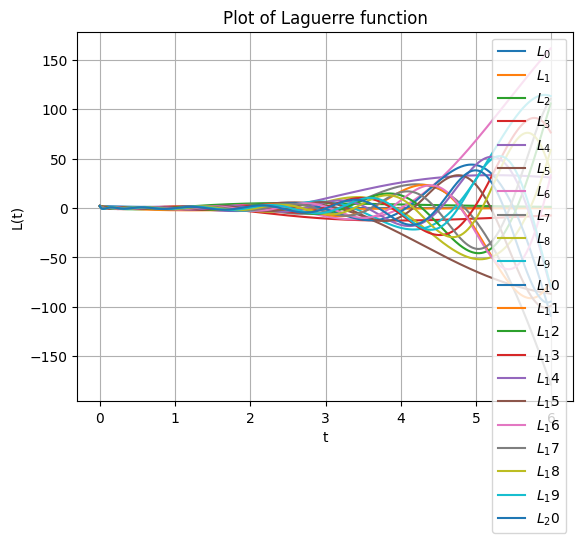

In [29]:
a = Laguerre(func_demian, 100, 2, 4, 20, 0.001)
Visualize.draw_lauguerre(a, 6)

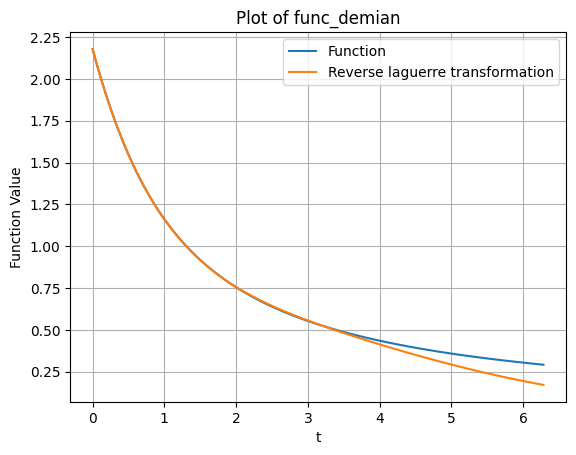

In [30]:
Visualize.draw_reverse_transformation(Laguerre(func_demian, 100, 2, 4, 5, 0.001), 0, 2*np.pi)

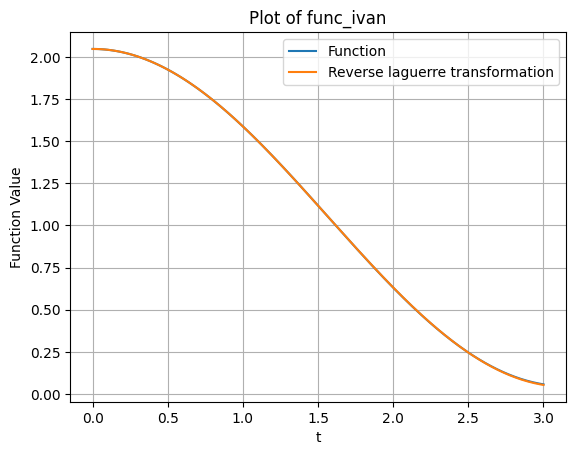

In [31]:
Visualize.draw_reverse_transformation(Laguerre(func_ivan, 100, 2, 4, 10, 0.001), 0, 3)

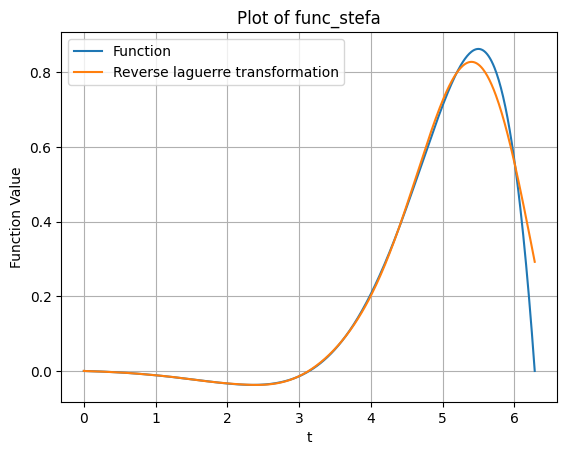

In [32]:
Visualize.draw_reverse_transformation(Laguerre(func_stefa, 100, 2, 4, 20, 0.001), 0, 2*np.pi)

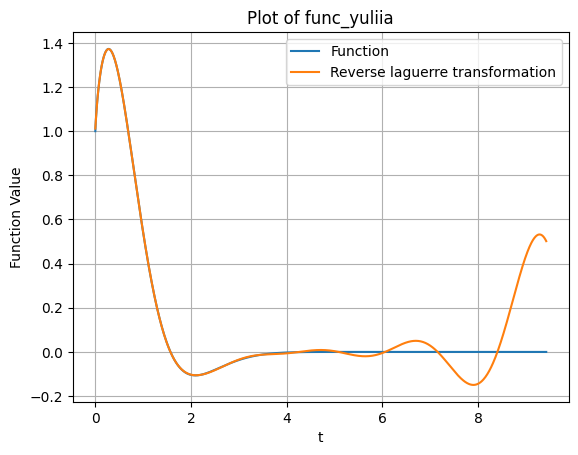

In [33]:
Visualize.draw_reverse_transformation(Laguerre(func_yuliia, 100, 2, 4, 20, 0.001), 0, 3*np.pi)

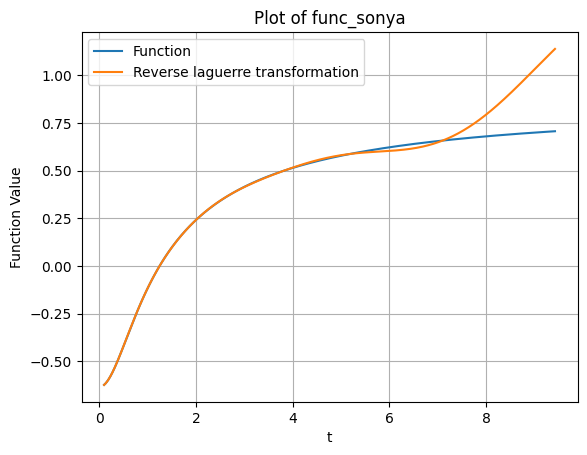

In [34]:
Visualize.draw_reverse_transformation(Laguerre(func_sonya, 100, 2, 4, 10, 0.001), 0.1, 3*np.pi)

In [35]:
a = UI(Laguerre(func_stefa, 100, 2, 4, 20, 0.001))
a.laguerre_func_ui()

interactive(children=(IntSlider(value=1, description='N', max=20, min=1), IntSlider(value=1, description='to',…

In [36]:
a.reverse_transformation_ui()

interactive(children=(IntSlider(value=1, description='N', max=20, min=1), IntSlider(value=100, description='T'…

In [37]:
a.tubulate_experiment_ui()

interactive(children=(IntSlider(value=1, description='N', max=20, min=1), IntSlider(value=100, description='T'…

In [39]:
a.tabulate_laguerre_ui()

interactive(children=(IntSlider(value=2, description='beta', max=20, min=1), IntSlider(value=4, description='s…

In [38]:
unittest.main(argv=[''], verbosity=3, exit=False)

test_constructor (__main__.Tests) ... ok
test_experiment (__main__.Tests) ... ok
test_experiment_tabulation (__main__.Tests) ... ok
test_integration_boundaries (__main__.Tests) ... ok
test_integration_equal (__main__.Tests) ... ok
test_integration_not_equal (__main__.Tests) ... ok
test_reverse_transformation (__main__.Tests) ... ok
test_solve_polynomial (__main__.Tests) ... ok

----------------------------------------------------------------------
Ran 8 tests in 4.239s

OK


In [1]:
tabulatedExperiment = pd.read_csv("../LaguerreCSharp/data/tabulatedExperiment.csv")
tabulatedExperiment

NameError: name 'pd' is not defined

In [ ]:
reverseTransformationData = pd.read_csv("data/reverseTransformationData.csv")
columns = reverseTransformationData.columns

function_names = [col for col in columns if col != 'x']

num_functions = len(function_names) // 2

fig, axs = plt.subplots(num_functions, 1, figsize=(10, 5*num_functions))

for i in range(num_functions):
    idx = i * 2
    func_name = function_names[idx].split("_")[0]
    transformed_name = function_names[idx + 1]

    axs[i].plot(reverseTransformationData['x'], reverseTransformationData[function_names[idx]], label="Function")
    axs[i].plot(reverseTransformationData['x'], reverseTransformationData[transformed_name], label="Reverse laguerre transformation", linestyle='--')
    axs[i].set_title(f'{func_name[4:]}\'s function')
    axs[i].legend()

plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
GaussReverseTransformationData = pd.read_csv("data/GaussReverseTransformationData.csv")
columns = GaussReverseTransformationData.columns

function_names = [col for col in columns if col != 'x']
function_names
num_functions = len(function_names) // 2

fig, axs = plt.subplots(num_functions, 1, figsize=(10, 5*num_functions))

for i in range(num_functions):
    idx = i * 2
    func_name = function_names[idx].split("_")[0]
    transformed_name = function_names[idx + 1]

    axs[i].plot(GaussReverseTransformationData['x'], GaussReverseTransformationData[function_names[idx]], label="Function")
    axs[i].plot(GaussReverseTransformationData['x'], GaussReverseTransformationData[transformed_name], label="Reverse laguerre transformation", linestyle='--')
    axs[i].set_title(f'{func_name} function')
    axs[i].legend()

plt.tight_layout()
plt.grid(True)
plt.show()